# Objective:
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from collections import Counter
from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 2.8MB/s 


In [0]:
link = 'https://drive.google.com/open?id=1T48h84GLW3dpy9F6ble5nF_1gQxBO8rx'

In [0]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1T48h84GLW3dpy9F6ble5nF_1gQxBO8rx


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train_data.csv')  
project_data = pd.read_csv('train_data.csv', nrows=60000)

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link='https://drive.google.com/open?id=14OVXWu_SJU-lJD-jKMOCld14EZ21lYYe'

In [0]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

14OVXWu_SJU-lJD-jKMOCld14EZ21lYYe


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('resources.csv')  
resources_data = pd.read_csv('resources.csv', nrows=60000)

In [0]:
print('The size of project data is:',project_data.shape)
print('The attributes of project data are:',project_data.columns.values)

The size of project data is: (60000, 17)
The attributes of project data are: ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [0]:
print('The size of resources data is:',resources_data.shape)
print('The attributes of resources data are:',resources_data.columns.values)

The size of resources data is: (60000, 4)
The attributes of resources data are: ['id' 'description' 'quantity' 'price']


In [0]:
project_data.head()

Unnamed: 0  ... project_is_approved
0      160221  ...                   0
1      140945  ...                   1
2       21895  ...                   0
3          45  ...                   1
4      172407  ...                   1

[5 rows x 17 columns]

In [0]:
resources_data.head()

id                                        description  quantity   price
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1  149.00
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   14.95
2  p069063  Cory Stories: A Kid's Book About Living With Adhd         1    8.45
3  p069063  Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...         2   13.59
4  p069063  EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...         3   24.95

# DATA ANALYSIS

In [0]:
project_data['project_is_approved'].value_counts()

1    50856
0     9144
Name: project_is_approved, dtype: int64

In [0]:
print('Total no of approved projects are:',project_data['project_is_approved'].value_counts()[1])
print('Total no of approved projects are:',project_data['project_is_approved'].value_counts()[0])

Total no of approved projects are: 50856
Total no of approved projects are: 9144


# Univariate Analysis: Project is approved

# Summary:-
All the states have more than 80% approval rate

In [0]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]

#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data['Date']=pd.to_datetime(project_data['project_submitted_datetime'])
project_data=project_data.drop('project_submitted_datetime', axis=1)
project_data.sort_values(by=['Date'], inplace=True)
# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]


project_data.head(2)

Unnamed: 0  ... project_is_approved
55660        8393  ...                   1
51140       74477  ...                   1

[2 rows x 17 columns]

# Univariate Analysis: Teacher prefix

In [0]:
project_data.columns.values

array(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'Date', 'project_grade_category', 'project_subject_categories',
       'project_subject_subcategories', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects',
       'project_is_approved'], dtype=object)

# preprocessing of `project_subject_categories`

In [0]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


# preprocessing of `project_subject_subcategories`

In [0]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

In [0]:
price_data = resources_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()

In [0]:
project_data=pd.merge(project_data, price_data, on='id', how='left')

In [0]:
project_data.shape

(60000, 19)

# Text preprocessing:-

In [0]:
Y= project_data['project_is_approved']
Y.values

array([1, 1, 1, ..., 1, 1, 1])

In [0]:
project_data.columns.values

array(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'Date', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects',
       'project_is_approved', 'clean_categories', 'clean_subcategories',
       'price', 'quantity'], dtype=object)

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [0]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
project_data = project_data.replace({'teacher_prefix':np.nan},"")
a=set(list(project_data['teacher_prefix'].values))
a

{'', 'Dr.', 'Mr.', 'Mrs.', 'Ms.', 'Teacher'}

In [0]:
a.remove('')

In [0]:
a

{'Dr.', 'Mr.', 'Mrs.', 'Ms.', 'Teacher'}

In [0]:
project_data.project_grade_category = project_data.project_grade_category.str.replace('\s+', '_')
project_data.project_grade_category = project_data.project_grade_category.str.replace('-', '_')
project_data['project_grade_category'].value_counts()

Grades_PreK_2    24257
Grades_3_5       20454
Grades_6_8        9262
Grades_9_12       6027
Name: project_grade_category, dtype: int64

In [0]:
project_data['essay']=project_data['project_essay_1'].map(str) +\
                      project_data['project_essay_2'].map(str) +\
                      project_data['project_essay_3'].map(str) +\
                      project_data['project_essay_4'].map(str) 

In [0]:
X = project_data.drop('project_is_approved', axis=1)
print(X.shape)
print(X.columns.values)
print('=================================================================')

X1, X_test, Y1, Y_test=train_test_split(X, Y, test_size=0.33, random_state=0, stratify=Y)
X_tr, X_cv, Y_tr, Y_cv=train_test_split(X1, Y1, test_size=0.33, random_state=0, stratify=Y1)

print("The shape of training data is:")
print(X_tr.shape)
print(Y_tr.shape)
print('==========')
print("The shape of test data is:")
print(X_test.shape)
print(Y_test.shape)
print('==========')
print("The shape of CV data is:")
print(X_cv.shape)
print(Y_cv.shape)

(60000, 19)
['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state' 'Date'
 'project_grade_category' 'project_title' 'project_essay_1'
 'project_essay_2' 'project_essay_3' 'project_essay_4'
 'project_resource_summary' 'teacher_number_of_previously_posted_projects'
 'clean_categories' 'clean_subcategories' 'price' 'quantity' 'essay']
The shape of training data is:
(26934, 19)
(26934,)
The shape of test data is:
(19800, 19)
(19800,)
The shape of CV data is:
(13266, 19)
(13266,)


In [0]:
preprocessed_1=[]
for sent in tqdm(X_tr['essay'].values):
    
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent=' '.join(e.lower() for e in sent.split() if e not in stopwords)
    sentance = decontracted(sent)
    preprocessed_1.append(sentance.strip())


100%|██████████| 26934/26934 [00:13<00:00, 1938.43it/s]


In [0]:
preprocessed_2=[]
for sent in tqdm(X_test['essay'].values):
    
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent=' '.join(e.lower() for e in sent.split() if e not in stopwords)
    sentance = decontracted(sent)
    preprocessed_2.append(sentance.strip())


100%|██████████| 19800/19800 [00:10<00:00, 1949.27it/s]


In [0]:
preprocessed_3=[]
for sent in tqdm(X_cv['essay'].values):
    
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent=' '.join(e.lower() for e in sent.split() if e not in stopwords)
    sentance = decontracted(sent)
    preprocessed_3.append(sentance.strip())


100%|██████████| 13266/13266 [00:06<00:00, 1962.51it/s]


In [0]:
preprocessed_title_1=[]
for sent in tqdm(X_tr['project_title'].values):
    
    sent = sent.replace('\\r', ' ')   
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent=' '.join(e.lower() for e in sent.split() if e not in stopwords)
    sentance=decontracted(sent)
    preprocessed_title_1.append(sentance.strip())


100%|██████████| 26934/26934 [00:00<00:00, 39352.36it/s]


In [0]:
preprocessed_title_2=[]
for sent in tqdm(X_test['project_title'].values):
    
    sent = sent.replace('\\r', ' ')   
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent=' '.join(e.lower() for e in sent.split() if e not in stopwords)
    sentance = decontracted(sent)
    preprocessed_title_2.append(sentance.strip())


100%|██████████| 19800/19800 [00:00<00:00, 40620.22it/s]


In [0]:
preprocessed_title_3=[]
for sent in tqdm(X_cv['project_title'].values):
    
    sent = sent.replace('\\r', ' ')   
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent=' '.join(e.lower() for e in sent.split() if e not in stopwords)
    sentance = decontracted(sent)
    preprocessed_title_3.append(sentance.strip())


100%|██████████| 13266/13266 [00:00<00:00, 39828.61it/s]


# <h2><font color='red'> Features to be considered </font></h2>

We are going to consider

   - school_state : categorical data
   - clean_categories : categorical data
   - clean_subcategories : categorical data
   - project_grade_category : categorical data
   - teacher_prefix : categorical data

   - project_title : text data
   - text : text data
   - project_resource_summary: text data (optinal)

   - quantity : numerical (optinal)
   - teacher_number_of_previously_posted_projects : numerical
   - price : numerical

# 1. Vectorizing categorical data

1. Subject Categories:-

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
vectorizer_1 = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
subject_categories_vect_1= vectorizer_1.fit_transform(X_tr['clean_categories'].values)
print(vectorizer_1.get_feature_names())
print('The shape of the train matrix after one hot encoding is:', subject_categories_vect_1.shape)
subject_categories_vect_2=vectorizer_1.transform(X_test['clean_categories'].values)
subject_categories_vect_3=vectorizer_1.transform(X_cv['clean_categories'].values)
print('The shape of the CV matrix after one hot encoding is:', subject_categories_vect_2.shape)
print('The shape of the test matrix after one hot encoding is:', subject_categories_vect_3.shape)


['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
The shape of the train matrix after one hot encoding is: (26934, 9)
The shape of the CV matrix after one hot encoding is: (19800, 9)
The shape of the test matrix after one hot encoding is: (13266, 9)


In [0]:
subject_categories_vect_1.toarray()[2]

array([0, 0, 0, 0, 0, 0, 1, 0, 0])

2. Subject sub_categories:-

In [0]:
vectorizer_2=CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
sub_categories_vect_1= vectorizer_2.fit_transform(X_tr['clean_subcategories'].values)
print(vectorizer_2.get_feature_names())
print('The shape of train encoded subcategories is:',sub_categories_vect_1.shape)
sub_categories_vect_2=vectorizer_2.transform(X_test['clean_subcategories'].values)
sub_categories_vect_3=vectorizer_2.transform(X_cv['clean_subcategories'].values)
print('The shape of the CV encoded subcategories is:', sub_categories_vect_2.shape)
print('The shape of the test encoded subcategories is:', sub_categories_vect_3.shape)


['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'History_Geography', 'Music', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
The shape of train encoded subcategories is: (26934, 30)
The shape of the CV encoded subcategories is: (19800, 30)
The shape of the test encoded subcategories is: (13266, 30)


In [0]:
sub_categories_vect_1.toarray()[2]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

3. School State

In [0]:
vectorizer_3=CountVectorizer(lowercase=False, binary=True)
school_state_vect_1 = vectorizer_3.fit_transform(X_tr['school_state'].values)
print(vectorizer_3.get_feature_names())
school_state_vect_2 = vectorizer_3.transform(X_test['school_state'].values)
school_state_vect_3 = vectorizer_3.transform(X_cv['school_state'].values)
print('The shape of the Train school state encoded subcategories is:', school_state_vect_1.shape)
print('The shape of the CV school state encoded subcategories is:', school_state_vect_2.shape)
print('The shape of the Test school state encoded subcategories is:', school_state_vect_3.shape)


['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
The shape of the Train school state encoded subcategories is: (26934, 51)
The shape of the CV school state encoded subcategories is: (19800, 51)
The shape of the Test school state encoded subcategories is: (13266, 51)


4. Teacher_Prefix

In [0]:
vectorizer_4=CountVectorizer(vocabulary=a, lowercase=False, binary=True)
teacher_prefix_vec_1=vectorizer_4.fit_transform(X_tr['teacher_prefix'].values)
teacher_prefix_vec_2=vectorizer_4.transform(X_test['teacher_prefix'].values)
teacher_prefix_vec_3=vectorizer_4.transform(X_cv['teacher_prefix'].values)
print(vectorizer_4.get_feature_names())
print('The shape of the Train encoded teacher_prefix is:', teacher_prefix_vec_1.shape)
print('The shape of the CV encoded teacher_prefix is:', teacher_prefix_vec_2.shape)
print('The shape of the Test encodedteacher_prefix is:', teacher_prefix_vec_3.shape)


['Dr.', 'Mr.', 'Mrs.', 'Ms.', 'Teacher']
The shape of the Train encoded teacher_prefix is: (26934, 5)
The shape of the CV encoded teacher_prefix is: (19800, 5)
The shape of the Test encodedteacher_prefix is: (13266, 5)


5. Project grade Category

In [0]:
vectorizer_5=CountVectorizer(lowercase=False, binary= True)
grade_category_vec_1=vectorizer_5.fit_transform(X_tr['teacher_prefix'].values)
grade_category_vec_2=vectorizer_5.transform(X_test['teacher_prefix'].values)
grade_category_vec_3=vectorizer_5.transform(X_cv['teacher_prefix'].values)
print(vectorizer_5.get_feature_names())
print('The shape of the Train encoded teacher_prefix is:', grade_category_vec_1.shape)
print('The shape of the CV encoded teacher_prefix is:', grade_category_vec_2.shape)
print('The shape of the Test encodedteacher_prefix is:', grade_category_vec_3.shape)


['Dr', 'Mr', 'Mrs', 'Ms', 'Teacher']
The shape of the Train encoded teacher_prefix is: (26934, 5)
The shape of the CV encoded teacher_prefix is: (19800, 5)
The shape of the Test encodedteacher_prefix is: (13266, 5)


# VECTORIZING TEXT DATA

1. BOW with essay data:-

In [0]:
vectorizer_6=CountVectorizer(min_df=10, max_features=2000)
vectorizer_6.fit(preprocessed_1)
essay_vec_1=vectorizer_6.fit_transform(preprocessed_1)
essay_vec_2=vectorizer_6.transform(preprocessed_2)
essay_vec_3=vectorizer_6.transform(preprocessed_3)

In [0]:
print('The shape of essay train data is',essay_vec_1.shape)
print('The shape of essay test data is',essay_vec_2.shape)
print('The shape of essay CV data is',essay_vec_3.shape)

The shape of essay train data is (26934, 2000)
The shape of essay test data is (19800, 2000)
The shape of essay CV data is (13266, 2000)


In [0]:
essay_vec_3.toarray()[100]

array([0, 0, 0, ..., 0, 0, 0])

2. BOW with project title data:-

In [0]:
vectorizer_7=CountVectorizer(min_df=10, max_features=2000)
vectorizer_6.fit(preprocessed_title_1)
title_vec_1=vectorizer_6.fit_transform(preprocessed_title_1)
title_vec_2=vectorizer_6.transform(preprocessed_title_2)
title_vec_3=vectorizer_6.transform(preprocessed_title_3)

In [0]:
print('The shape of title train data is',title_vec_1.shape)
print('The shape of title test data is',title_vec_2.shape)
print('The shape of title CV data is',title_vec_3.shape)

The shape of title train data is (26934, 1410)
The shape of title test data is (19800, 1410)
The shape of title CV data is (13266, 1410)


In [0]:
title_vec_3.toarray()[4000]

array([0, 0, 0, ..., 0, 0, 0])

3. TFIDF with essay data:-

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_8 = TfidfVectorizer(min_df=10, max_features=2000)
essay_vec_4 = vectorizer_8.fit_transform(preprocessed_1)
essay_vec_5 = vectorizer_8.transform(preprocessed_2)
essay_vec_6 = vectorizer_8.transform(preprocessed_3)
print('The shape of essay tfidf train data is',essay_vec_4.shape)
print('The shape of essay tfidf test data is',essay_vec_5.shape)
print('The shape of essay tfidf CV data is',essay_vec_6.shape)

The shape of essay tfidf train data is (26934, 2000)
The shape of essay tfidf test data is (19800, 2000)
The shape of essay tfidf CV data is (13266, 2000)


In [0]:
essay_vec_6.toarray()[100]

array([0., 0., 0., ..., 0., 0., 0.])

4. TFIDF with title data:-

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_9 = TfidfVectorizer(min_df=10, max_features=2000)
title_vec_4 = vectorizer_9.fit_transform(preprocessed_title_1)
title_vec_5 = vectorizer_9.transform(preprocessed_title_2)
title_vec_6 = vectorizer_9.transform(preprocessed_title_3)
print('The shape of title tfidf train data is',title_vec_4.shape)
print('The shape of title tfidf test data is',title_vec_5.shape)
print('The shape of title tfidf CV data is',title_vec_6.shape)

The shape of title tfidf train data is (26934, 1410)
The shape of title tfidf test data is (19800, 1410)
The shape of title tfidf CV data is (13266, 1410)


In [0]:
title_vec_6.toarray()[2000]

array([0., 0., 0., ..., 0., 0., 0.])

In [0]:
if not os.path.exists('glove.6B.zip'):
    ! wget http://nlp.stanford.edu/data/glove.6B.zip
if not os.path.exists('glove.6B.300d.txt'):
    ! unzip glove.6B.zip

--2019-07-14 18:45:20--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-07-14 18:45:20--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-07-14 18:45:20--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

# W2V:-

In [0]:



def loadGloveModel(gloveFile):
  print ("Loading Glove Model")
  f = open(gloveFile,'r', encoding="utf8")
  model = {}
  for line in tqdm(f):
    splitLine = line.split()
    word = splitLine[0]
    embedding = np.array([float(val) for val in splitLine[1:]])
    model[word] = embedding
  print ("Done.",len(model)," words loaded!")
  return model
model = loadGloveModel('glove.6B.300d.txt')

1013it [00:00, 10126.03it/s]

Loading Glove Model


400000it [00:37, 10766.98it/s]

Done. 400000  words loaded!


In [0]:
preprocessed = preprocessed_1 + preprocessed_2 + preprocessed_3
preprocessed_title = preprocessed_title_1 + preprocessed_title_2 + preprocessed_title_3

words = []
for i in preprocessed:
    words.extend(i.split(' '))

for i in preprocessed_title:
    words.extend(i.split(' '))  
print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys()) 
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))


# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_courpus, f)

all the words in the coupus 9321566
the unique words in the coupus 46132
The number of words that are present in both glove vectors and our coupus 37067 ( 80.35 %)
word 2 vec length 37067


In [0]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [0]:
#Avg W2v on essay:-#

In [0]:
avg_w2v_vectors_1 = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_1): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_1.append(vector)

print(len(avg_w2v_vectors_1))
print(len(avg_w2v_vectors_1[0]))

100%|██████████| 26934/26934 [00:07<00:00, 3824.31it/s]

26934
300


In [0]:
avg_w2v_vectors_2 = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_2): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_2.append(vector)

print(len(avg_w2v_vectors_2))
print(len(avg_w2v_vectors_2[0]))

100%|██████████| 19800/19800 [00:05<00:00, 3931.84it/s]

19800
300


In [0]:
avg_w2v_vectors_3 = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_3): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_3.append(vector)

print(len(avg_w2v_vectors_3))
print(len(avg_w2v_vectors_3[0]))

100%|██████████| 13266/13266 [00:03<00:00, 3876.10it/s]

13266
300


In [0]:
#Avg W2v on project title:-

In [0]:
title_vectors_1 = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_title_1): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    title_vectors_1.append(vector)

print(len(title_vectors_1))
print(len(title_vectors_1[0]))

100%|██████████| 26934/26934 [00:00<00:00, 81184.10it/s]

26934
300


In [0]:
title_vectors_2 = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_title_2): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    title_vectors_2.append(vector)

print(len(title_vectors_2))
print(len(title_vectors_2[0]))

100%|██████████| 19800/19800 [00:00<00:00, 78711.92it/s]

19800
300


In [0]:
title_vectors_3 = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_title_3): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    title_vectors_3.append(vector)

print(len(title_vectors_3))
print(len(title_vectors_3[0]))

100%|██████████| 13266/13266 [00:00<00:00, 80918.22it/s]

13266
300


In [0]:
#Tf-idf W2V on essay:-

In [0]:
tfidf_model_1 = TfidfVectorizer()
tfidf_model_1.fit(preprocessed_1)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_1 = dict(zip(tfidf_model_1.get_feature_names(), list(tfidf_model_1.idf_)))
tfidf_words_1 = set(tfidf_model_1.get_feature_names())

In [0]:
tfidf_w2v_vectors_1 = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_1): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words_1):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary_1[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_1.append(vector)

print(len(tfidf_w2v_vectors_1))
print(len(tfidf_w2v_vectors_1[0]))

100%|██████████| 26934/26934 [00:43<00:00, 625.23it/s]

26934
300


In [0]:
tfidf_w2v_vectors_2 = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_2): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words_1):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary_1[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_2.append(vector)

print(len(tfidf_w2v_vectors_2))
print(len(tfidf_w2v_vectors_2[0]))

100%|██████████| 19800/19800 [00:31<00:00, 621.67it/s]

19800
300


In [0]:
tfidf_w2v_vectors_3 = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_3): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words_1):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary_1[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_3.append(vector)

print(len(tfidf_w2v_vectors_3))
print(len(tfidf_w2v_vectors_3[0]))

100%|██████████| 13266/13266 [00:21<00:00, 614.11it/s]

13266
300


In [0]:
#Tf-idf W2V on project_title:-

In [0]:
tfidf_title_model_1 = TfidfVectorizer()
tfidf_title_model_1.fit(preprocessed_title_1)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary1 = dict(zip(tfidf_title_model_1.get_feature_names(), list(tfidf_title_model_1.idf_)))
tfidf_title_words_1 = set(tfidf_title_model_1.get_feature_names())

In [0]:
tfidf_title_w2v_vectors_1 = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_title_1): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_title_words_1):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary1[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_title_w2v_vectors_1.append(vector)

print(len(tfidf_title_w2v_vectors_1))
print(len(tfidf_title_w2v_vectors_1[0]))

100%|██████████| 26934/26934 [00:00<00:00, 32998.01it/s]

26934
300


In [0]:
tfidf_title_w2v_vectors_2 = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_title_2): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_title_words_1):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary1[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_title_w2v_vectors_2.append(vector)

print(len(tfidf_title_w2v_vectors_2))
print(len(tfidf_title_w2v_vectors_2[0]))

100%|██████████| 19800/19800 [00:00<00:00, 36271.43it/s]

19800
300


In [0]:
tfidf_title_w2v_vectors_3 = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_title_3): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_title_words_1):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary1[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_title_w2v_vectors_3.append(vector)

print(len(tfidf_title_w2v_vectors_3))
print(len(tfidf_title_w2v_vectors_3[0]))

100%|██████████| 13266/13266 [00:00<00:00, 35906.45it/s]

13266
300


# VECTORIZING NUMERICAL DATA:-

1. Project price:-

In [0]:
from sklearn.preprocessing import Normalizer

from numpy import *

# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

where_are_NaNs = isnan(X_tr['price'])
X_tr['price'][where_are_NaNs] = 0

where_are_NaNs = isnan(X_test['price'])
X_test['price'][where_are_NaNs] = 0

where_are_NaNs = isnan(X_cv['price'])
X_cv['price'][where_are_NaNs] = 0

price_normalize = Normalizer()
price_normalize.fit(X_tr['price'].values.reshape(1,-1)) # finding the mean and standard deviation of this data

# Now standardize the data with above maen and variance.
price_normalized_1 = price_normalize.transform(X_tr['price'].values.reshape(1,-1))
price_normalized_2 = price_normalize.transform(X_test['price'].values.reshape(1,-1))
price_normalized_3 = price_normalize.transform(X_cv['price'].values.reshape(1,-1))

print(price_normalized_1.shape)
print(price_normalized_2.shape)
print(price_normalized_3.shape)

(1, 26934)
(1, 19800)
(1, 13266)


In [0]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import Normalizer
import warnings
warnings.filterwarnings("ignore")

# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

previousproject_normalize = Normalizer()
previousproject_normalize.fit(X_tr['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)) # finding the mean and standard deviation of this data

# Now standardize the data with above maen and variance.
previousproject_normalize_1 = previousproject_normalize.transform(X_tr['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
previousproject_normalize_2 = previousproject_normalize.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
previousproject_normalize_3 = previousproject_normalize.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
print(previousproject_normalize_1.shape)
print(previousproject_normalize_2.shape)
print(previousproject_normalize_3.shape)

(1, 26934)
(1, 19800)
(1, 13266)


# CONCATENATION OF FEATURES:-

1. Concatenating categorical, numerical and BOW encoded text features :-

In [0]:
from scipy.sparse import hstack
X_train_1 = hstack((subject_categories_vect_1, sub_categories_vect_1, school_state_vect_1, teacher_prefix_vec_1, grade_category_vec_1, essay_vec_1, title_vec_1, price_normalized_1.T, previousproject_normalize_1.T))
X_train_1.shape

(26934, 3512)

In [0]:
from scipy.sparse import hstack
X_test_1 = hstack((subject_categories_vect_2, sub_categories_vect_2, school_state_vect_2, teacher_prefix_vec_2, grade_category_vec_2, essay_vec_2, title_vec_2, price_normalized_2.T, previousproject_normalize_2.T))
X_test_1.shape

(19800, 3512)

In [0]:
from scipy.sparse import hstack
X_cv_1 = hstack((subject_categories_vect_3, sub_categories_vect_3, school_state_vect_3, teacher_prefix_vec_3, grade_category_vec_3, essay_vec_3, title_vec_3, price_normalized_3.T, previousproject_normalize_3.T))
X_cv_1.shape

(13266, 3512)

1. Concatenating categorical, numerical and TFIDF encoded text features :-

In [0]:
from scipy.sparse import hstack
X_train_2 = hstack((subject_categories_vect_1, sub_categories_vect_1, school_state_vect_1, teacher_prefix_vec_1, grade_category_vec_1, essay_vec_4, title_vec_4, price_normalized_1.T, previousproject_normalize_1.T))
X_train_2.shape

(26934, 3512)

In [0]:
from scipy.sparse import hstack
X_test_2 = hstack((subject_categories_vect_2, sub_categories_vect_2, school_state_vect_2, teacher_prefix_vec_2, grade_category_vec_2, essay_vec_5, title_vec_5, price_normalized_2.T, previousproject_normalize_2.T))
X_test_2.shape

(19800, 3512)

In [0]:
from scipy.sparse import hstack
X_cv_2 = hstack((subject_categories_vect_3, sub_categories_vect_3, school_state_vect_3, teacher_prefix_vec_3, grade_category_vec_3, essay_vec_6, title_vec_6, price_normalized_3.T, previousproject_normalize_3.T))
X_cv_2.shape

(13266, 3512)

3.Concatenating categorical, numerical and Avg_W2v encoded text features :-

In [0]:
from scipy.sparse import hstack
X_train_3 = hstack((subject_categories_vect_1, sub_categories_vect_1, school_state_vect_1, teacher_prefix_vec_1, grade_category_vec_1, avg_w2v_vectors_1, title_vectors_1, price_normalized_1.T, previousproject_normalize_1.T))
X_train_3.shape

(26934, 702)

In [0]:
from scipy.sparse import hstack
X_test_3 = hstack((subject_categories_vect_2, sub_categories_vect_2, school_state_vect_2, teacher_prefix_vec_2, grade_category_vec_2, avg_w2v_vectors_2, title_vectors_2, price_normalized_2.T, previousproject_normalize_2.T))
X_test_3.shape

(19800, 702)

In [0]:
from scipy.sparse import hstack
X_cv_3 = hstack((subject_categories_vect_3, sub_categories_vect_3, school_state_vect_3, teacher_prefix_vec_3, grade_category_vec_3, avg_w2v_vectors_3, title_vectors_3, price_normalized_3.T, previousproject_normalize_3.T))
X_cv_3.shape

(13266, 702)

3.Concatenating categorical, numerical and Tfidf_W2v encoded text features :-

In [0]:
from scipy.sparse import hstack
X_train_4 = hstack((subject_categories_vect_1, sub_categories_vect_1, school_state_vect_1, teacher_prefix_vec_1, grade_category_vec_1, tfidf_w2v_vectors_1, tfidf_title_w2v_vectors_1, price_normalized_1.T, previousproject_normalize_1.T))
X_train_4.shape

(26934, 702)

In [0]:
from scipy.sparse import hstack
X_test_4 = hstack((subject_categories_vect_2, sub_categories_vect_2, school_state_vect_2, teacher_prefix_vec_2, grade_category_vec_2, tfidf_w2v_vectors_2, tfidf_title_w2v_vectors_2, price_normalized_2.T, previousproject_normalize_2.T))
X_test_4.shape

(19800, 702)

In [0]:
from scipy.sparse import hstack
X_cv_4 = hstack((subject_categories_vect_3, sub_categories_vect_3, school_state_vect_3, teacher_prefix_vec_3, grade_category_vec_3, tfidf_w2v_vectors_3, tfidf_title_w2v_vectors_3, price_normalized_3.T, previousproject_normalize_3.T))
X_cv_4.shape

(13266, 702)

# MODEL_1 :- KNN-Brute Force + BOW encoding

In [0]:
print(X_train_1.shape)
print(X_test_1.shape)
print(X_cv_1.shape)
print(Y_tr.shape)
print(Y_test.shape)
print(Y_cv.shape)

(26934, 3512)
(19800, 3512)
(13266, 3512)
(26934,)
(19800,)
(13266,)


In [0]:
k = [i for i in range(1, 601) if i%15==0]


 Hyperparameter tuning to find the best-K:

In [0]:
import math
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
auc_score_1=list()
auc_score_2=list()

In [0]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [0]:
from sklearn.neighbors import KNeighborsClassifier
for i in tqdm(k):
    neighbour =  KNeighborsClassifier(n_neighbors=i, n_jobs=-1, algorithm='brute')
    clf=neighbour.fit(X_train_1, Y_tr)
    Y_pred_1 = batch_predict(clf, X_train_1.tocsr())    
    Y_pred_2 = batch_predict(clf, X_cv_1.tocsr())
    auc_1=roc_auc_score(Y_tr, Y_pred_1)
    auc_score_1.append(auc_1)
    auc_2=roc_auc_score(Y_cv, Y_pred_2)
    auc_score_2.append(auc_2)

100%|██████████| 40/40 [1:11:20<00:00, 106.68s/it]


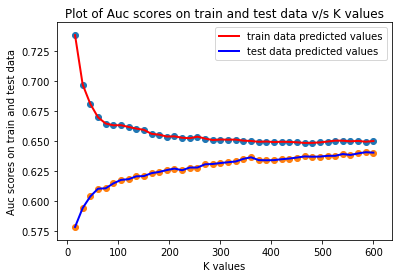

In [0]:
import matplotlib.pyplot as plt
plt.title('Plot of Auc scores on train and test data v/s K values')
plt.plot(k, auc_score_1, linewidth=2, color='r', label='train data predicted values')
plt.plot(k, auc_score_2, linewidth=2, color='b', label='test data predicted values')
plt.scatter(k, auc_score_1)
plt.scatter(k, auc_score_2)

plt.xlabel('K values')
plt.ylabel('Auc scores on train and test data')
plt.legend() 
plt.show() 

In [0]:
print('The train and CV auc scores are good at k = 540')
best_k1=540

The train and CV auc scores are good at k = 540


In [0]:
print('The AUC scores of the best k = 540 on train and CV data are {} and {}'.format(auc_score_1[35], auc_score_2[35]))

The AUC scores of the best k = 540 on train and CV data are 0.6503964861477195 and 0.6393214967974128


Training final model with best_k:-

In [0]:
neighbor = KNeighborsClassifier(n_neighbors=best_k1, algorithm='brute')
knn_1=neighbor.fit(X_train_1.tocsr(), Y_tr)
Y_pred_k1=batch_predict(knn_1, X_test_1.tocsr())
auc_score = roc_auc_score(Y_test, Y_pred_k1)
print(' The AUC score at best k = {} on test data for model M1 is {}'.format(best_k1, auc_score))

 The AUC score at best k = 540 on test data for model M1 is 0.6411866267141124


In [0]:
#ROC Curve:-

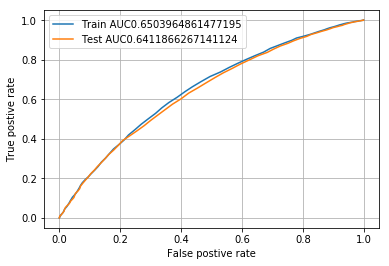

In [0]:
neighbor = KNeighborsClassifier(n_neighbors=best_k1, algorithm='brute', n_jobs=-1)
knn_1=neighbor.fit(X_train_1.tocsr(), Y_tr)
y_train_pred = batch_predict(knn_1, X_train_1.tocsr())    
y_test_pred = batch_predict(knn_1, X_test_1.tocsr())
train_fpr, train_tpr, train_threshold = roc_curve(Y_tr, y_train_pred)
test_fpr, test_tpr, test_threshold = roc_curve(Y_test, y_test_pred)
plt.plot(train_fpr, train_tpr, label='Train AUC' + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label='Test AUC' + str(auc(test_fpr, test_tpr)))
plt.xlabel('False postive rate')
plt.ylabel('True postive rate')
plt.grid()
plt.legend()
plt.show()

In [0]:
print('The AUC scores of the best k = {} on train and test data are {} and {}.'.format(best_k1, auc(train_fpr, train_tpr), auc(test_fpr, test_tpr)))

The AUC scores of the best k = 540 on train and test data are 0.6503964861477195 and 0.6411866267141124.


In [0]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [0]:
from sklearn.metrics import confusion_matrix

In [0]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(train_threshold, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(Y_tr, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.374975686893293 for threshold 0.815
Train confusion matrix
[[ 2411  1693]
 [ 8258 14572]]
Test confusion matrix
[[ 1735  1283]
 [ 6187 10595]]


In [0]:
confusion_matrix_train_1 = pd.DataFrame(confusion_matrix(Y_tr, predict_with_best_t(y_train_pred, best_t)))

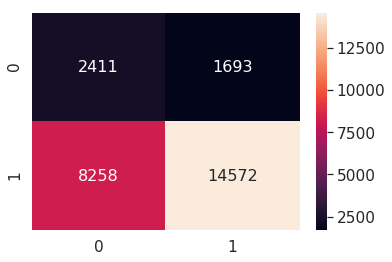

In [0]:
sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix_train_1, annot=True, annot_kws={'size':16}, fmt='g')

In [0]:
confusion_matrix_test_1 = pd.DataFrame(confusion_matrix(Y_test, predict_with_best_t(y_test_pred, best_t)))

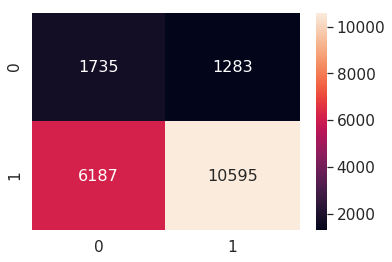

In [0]:
sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix_test_1, annot=True, annot_kws={'size':16}, fmt='g')

# MODEL_2 :- KNN-Brute Force + TFIDF encoding

In [0]:
print(X_train_2.shape)
print(X_test_2.shape)
print(X_cv_2.shape)
print(Y_tr.shape)
print(Y_test.shape)
print(Y_cv.shape)

(26934, 3512)
(19800, 3512)
(13266, 3512)
(26934,)
(19800,)
(13266,)


 Hyperparameter tuning to find the best-K:

In [0]:
import math
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

auc_score_3=list()
auc_score_4=list()

In [0]:
from sklearn.neighbors import KNeighborsClassifier
for i in tqdm(k):
    neighbour =  KNeighborsClassifier(n_neighbors=i, n_jobs=-1, algorithm='brute')
    clf=neighbour.fit(X_train_2.tocsr(), Y_tr)
    Y_pred_3=batch_predict(clf, X_train_2.tocsr())
    Y_pred_4=batch_predict(clf, X_cv_2.tocsr())
    auc_3=roc_auc_score(Y_tr, Y_pred_3)
    auc_score_3.append(auc_3)
    auc_4=roc_auc_score(Y_cv, Y_pred_4)
    auc_score_4.append(auc_4)


100%|██████████| 40/40 [1:12:32<00:00, 109.26s/it]


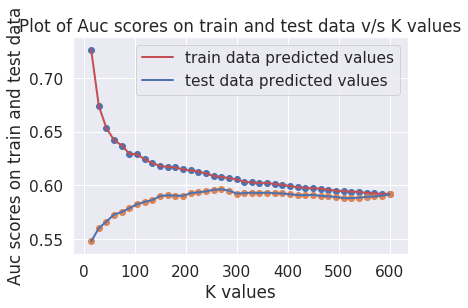

In [0]:
import matplotlib.pyplot as plt
plt.title('Plot of Auc scores on train and test data v/s K values')
plt.plot(k, auc_score_3, linewidth=2, color='r', label='train data predicted values')
plt.plot(k, auc_score_4, linewidth=2, color='b', label='test data predicted values')
plt.scatter(k, auc_score_3)
plt.scatter(k, auc_score_4)
plt.xlabel('K values')
plt.ylabel('Auc scores on train and test data')
plt.legend()
plt.show()

In [0]:
print('The AUC scores of the best k = 270 on train and CV data are 0.5012 and 0.5006')
best_k2=270

The AUC scores of the best k = 270 on train and CV data are 0.5012 and 0.5006


Training final model with best_k:-

In [0]:
#ROC Curve:-

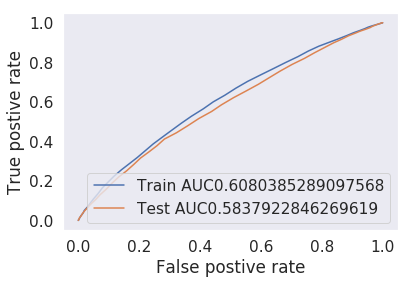

In [0]:
neighbor = KNeighborsClassifier(n_neighbors=best_k2, algorithm='brute')
knn_1=neighbor.fit(X_train_2.tocsr(), Y_tr)
Y_1=batch_predict(knn_1, X_train_2.tocsr())
train_fpr, train_tpr, train_threshold = roc_curve(Y_tr, Y_1)
Y_2=batch_predict(knn_1, X_test_2.tocsr())
test_fpr, test_tpr, test_threshold = roc_curve(Y_test, Y_2)
plt.plot(train_fpr, train_tpr, label='Train AUC' + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label='Test AUC' + str(auc(test_fpr, test_tpr)))
plt.xlabel('False postive rate')
plt.ylabel('True postive rate')
plt.grid()
plt.legend()
plt.show()

In [0]:
print('The AUC scores of the best k = {} on train and CV data are {} and {}'.format(best_k2, auc(train_fpr, train_tpr), auc(test_fpr, test_tpr)))


The AUC scores of the best k = 270 on train and CV data are 0.6080385289097568 and 0.5837922846269619


In [0]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(train_threshold, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(Y_tr, predict_with_best_t(Y_1, best_t)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, predict_with_best_t(Y_2, best_t)))

the maximum value of tpr*(1-fpr) 0.33382062007600893 for threshold 0.844
Train confusion matrix
[[ 2284  1820]
 [ 9136 13694]]
Test confusion matrix
[[1599 1419]
 [6971 9811]]


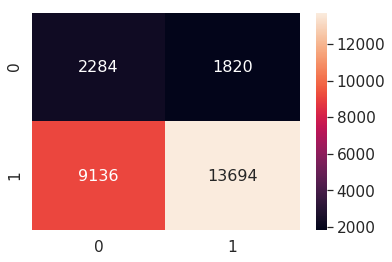

In [0]:
confusion_matrix_tr_df2=pd.DataFrame(confusion_matrix(Y_tr, predict_with_best_t(Y_1, best_t)))
sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix_tr_df2, annot=True, annot_kws={'size':16}, fmt='g')

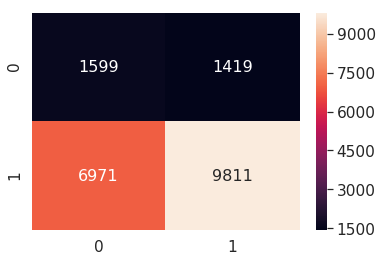

In [0]:
confusion_matrix_test_df2=pd.DataFrame(confusion_matrix(Y_test, predict_with_best_t(Y_2, best_t)))
sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix_test_df2, annot=True, annot_kws={'size':16}, fmt='g')

# MODEL_3 :- KNN-Brute Force + Avg-W2V encoding

In [0]:
print(X_train_3.shape)
print(X_test_3.shape)
print(X_cv_3.shape)
print(Y_tr.shape)
print(Y_test.shape)
print(Y_cv.shape)

(26934, 702)
(19800, 702)
(13266, 702)
(26934,)
(19800,)
(13266,)


 Hyperparameter tuning to find the best-K:

In [0]:
import math
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
auc_score_5=list()
auc_score_6=list()

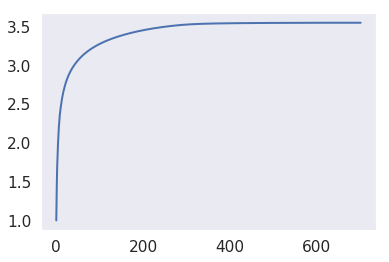

In [0]:
from sklearn.decomposition import PCA

pca=PCA()
pca.n_components=702
pca_data1 = pca.fit_transform(X_train_3.todense())


perc_var_explained = pca.explained_variance_/np.cumsum(pca.explained_variance_)
cumulative_variance = np.cumsum(perc_var_explained)

plt.plot(cumulative_variance, linewidth=2)
plt.grid()
plt.show()

In [0]:
print('Even after using top 200 features, more than 90% data is retained.')

Even after using top 200 features, more than 90% data is retained.


In [0]:
pca=PCA()
pca.n_components=200
pca_data_train = pca.fit_transform(X_train_3.todense())
pca_data_test = pca.fit_transform(X_test_3.todense())
pca_data_cv = pca.fit_transform(X_cv_3.todense())

In [0]:
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
for i in tqdm(k):
    neighbour =  KNeighborsClassifier(n_neighbors=i, algorithm='brute', n_jobs=-1)
    clf=neighbour.fit(pca_data_train, Y_tr)
    Y_pred_5=batch_predict(clf, pca_data_train)
    Y_pred_6=batch_predict(clf, pca_data_cv)
    auc_5=roc_auc_score(Y_tr, Y_pred_5)
    auc_score_5.append(auc_5)
    auc_6=roc_auc_score(Y_cv, Y_pred_6)
    auc_score_6.append(auc_6)



  0%|          | 0/40 [00:00<?, ?it/s]

  2%|▎         | 1/40 [00:54<35:23, 54.45s/it]

  5%|▌         | 2/40 [01:48<34:27, 54.42s/it]

  8%|▊         | 3/40 [02:43<33:31, 54.37s/it]

 10%|█         | 4/40 [03:37<32:38, 54.41s/it]

 12%|█▎        | 5/40 [04:31<31:41, 54.32s/it]

 15%|█▌        | 6/40 [05:26<30:51, 54.46s/it]

 18%|█▊        | 7/40 [06:20<29:54, 54.39s/it]

 20%|██        | 8/40 [07:15<29:00, 54.40s/it]

 22%|██▎       | 9/40 [08:09<28:07, 54.43s/it]

 25%|██▌       | 10/40 [09:04<27:17, 54.58s/it]

 28%|██▊       | 11/40 [09:59<26:24, 54.63s/it]

 30%|███       | 12/40 [10:54<25:33, 54.76s/it]

 32%|███▎      | 13/40 [11:49<24:43, 54.93s/it]

 35%|███▌      | 14/40 [12:44<23:48, 54.95s/it]

 38%|███▊      | 15/40 [13:39<22:51, 54.88s/it]

 40%|████      | 16/40 [14:34<22:00, 55.00s/it]

 42%|████▎     | 17/40 [15:30<21:07, 55.11s/it]

 45%|████▌     | 18/40 [16:26<20:21, 55.52s/it]

 48%|████▊     | 19/40 [17:22<19:30, 55.75s/it]

 50%|█████     | 20/40 [18:18<18:34,

In [0]:
print(len(k))
print(len(auc_score_5))
print(len(auc_score_6))

40
40
40


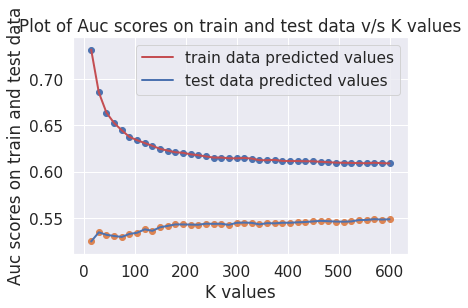

In [0]:
import matplotlib.pyplot as plt
plt.title('Plot of Auc scores on train and test data v/s K values')
plt.plot(k, auc_score_5, linewidth=2, color='r', label='train data predicted values')
plt.plot(k, auc_score_6, linewidth=2, color='b', label='test data predicted values')
plt.scatter(k, auc_score_5)
plt.scatter(k, auc_score_6)
plt.xlabel('K values')
plt.ylabel('Auc scores on train and test data')
plt.legend()
plt.show()

In [0]:
print('Best train and test AUC scores ocurr at k=450')
best_k3=450

Best train and test AUC scores ocurr at k=450


In [0]:
neighbor = KNeighborsClassifier(n_neighbors=best_k3, algorithm='brute')
knn_3=neighbor.fit(pca_data_train, Y_tr)
Y_pred_k3=batch_predict(knn_3, pca_data_test)
auc_score = roc_auc_score(Y_test, Y_pred_k3)
print(' The AUC score at best k = {} on test data for model M1 is {}'.format(best_k3, auc_score))

 The AUC score at best k = 450 on test data for model M1 is 0.5541638837376568


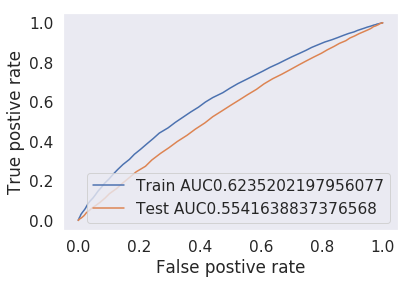

In [0]:
neighbor = KNeighborsClassifier(n_neighbors=best_k3, algorithm='brute')
knn_3=neighbor.fit(pca_data_train, Y_tr)
Y_1=batch_predict(knn_3, pca_data_train)
train_fpr, train_tpr, train_threshold = roc_curve(Y_tr, Y_1)
Y_2=batch_predict(knn_3, pca_data_test)
test_fpr, test_tpr, test_threshold = roc_curve(Y_test, Y_2)
plt.plot(train_fpr, train_tpr, label='Train AUC' + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label='Test AUC' + str(auc(test_fpr, test_tpr)))
plt.xlabel('False postive rate')
plt.ylabel('True postive rate')
plt.grid()
plt.legend()
plt.show()

In [0]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(train_threshold, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(Y_tr, predict_with_best_t(Y_1, best_t)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, predict_with_best_t(Y_2, best_t)))

the maximum value of tpr*(1-fpr) 0.34875198411173697 for threshold 0.851
Train confusion matrix
[[ 2390  1714]
 [ 9158 13672]]
Test confusion matrix
[[ 1420  1598]
 [ 6546 10236]]


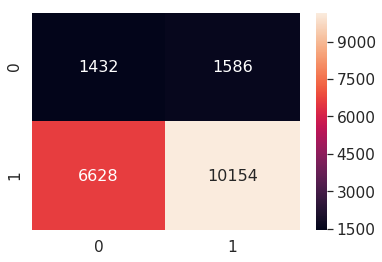

In [0]:
confusion_matrix_train_df2=pd.DataFrame(confusion_matrix(Y_tr, predict_with_best_t(Y_1, best_t)))
sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix_test_df2, annot=True, annot_kws={'size':16}, fmt='g')

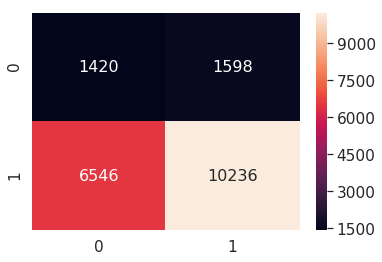

In [0]:
confusion_matrix_test_df2=pd.DataFrame(confusion_matrix(Y_test, predict_with_best_t(Y_2, best_t)))
sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix_test_df2, annot=True, annot_kws={'size':16}, fmt='g')

# MODEL_4 :- KNN-Brute Force + TFIDF-W2V encoding

In [0]:
print(X_train_4.shape)
print(X_test_4.shape)
print(X_cv_4.shape)
print(Y_tr.shape)
print(Y_test.shape)
print(Y_cv.shape)

(26934, 702)
(19800, 702)
(13266, 702)
(26934,)
(19800,)
(13266,)


 Hyperparameter tuning to find the best-K:

In [0]:
import math
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
auc_score_7=list()
auc_score_8=list()

In [0]:
from sklearn.decomposition import PCA

pca=PCA()
pca.n_components=702
pca_data1 = pca.fit_transform(X_train_4.todense())

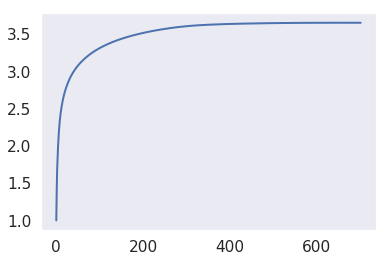

In [0]:

perc_var_explained = pca.explained_variance_/np.cumsum(pca.explained_variance_)
cumulative_variance = np.cumsum(perc_var_explained)

plt.plot(cumulative_variance, linewidth=2)
plt.grid()
plt.show()

In [0]:
print('Even using top 200 features, more than 90% of data is retained, thus we will use only top 200 features for TIIDF W2V model')

Even using top 200 features, more than 90% of data is retained, thus we will use only top 200 features for TIIDF W2V model


In [0]:
pca=PCA()
pca.n_components=200
pca_data_train = pca.fit_transform(X_train_4.todense())
pca_data_test = pca.fit_transform(X_test_4.todense())
pca_data_cv = pca.fit_transform(X_cv_4.todense())

In [0]:
from sklearn.neighbors import KNeighborsClassifier
for i in tqdm(k):
    neighbour =  KNeighborsClassifier(n_neighbors=i, algorithm = 'brute', n_jobs=-1)
    clf=neighbour.fit(pca_data_train, Y_tr)
    Y_pred_7=batch_predict(clf, pca_data_train)
    Y_pred_8=batch_predict(clf, pca_data_cv)
    auc_7=roc_auc_score(Y_tr, Y_pred_7)
    auc_score_7.append(auc_7)
    auc_8=roc_auc_score(Y_cv, Y_pred_8)
    auc_score_8.append(auc_8)



  0%|          | 0/40 [00:00<?, ?it/s]

  2%|▎         | 1/40 [00:54<35:11, 54.14s/it]

  5%|▌         | 2/40 [01:47<34:10, 53.95s/it]

  8%|▊         | 3/40 [02:41<33:17, 53.99s/it]

 10%|█         | 4/40 [03:36<32:26, 54.08s/it]

 12%|█▎        | 5/40 [04:30<31:40, 54.29s/it]

 15%|█▌        | 6/40 [05:25<30:45, 54.27s/it]

 18%|█▊        | 7/40 [06:19<29:51, 54.30s/it]

 20%|██        | 8/40 [07:14<29:01, 54.43s/it]

 22%|██▎       | 9/40 [08:09<28:12, 54.61s/it]

 25%|██▌       | 10/40 [09:04<27:21, 54.73s/it]

 28%|██▊       | 11/40 [09:59<26:31, 54.89s/it]

 30%|███       | 12/40 [10:54<25:37, 54.92s/it]

 32%|███▎      | 13/40 [11:49<24:44, 54.98s/it]

 35%|███▌      | 14/40 [12:44<23:45, 54.83s/it]

 38%|███▊      | 15/40 [13:39<22:54, 54.97s/it]

 40%|████      | 16/40 [14:34<21:58, 54.92s/it]

 42%|████▎     | 17/40 [15:29<21:07, 55.12s/it]

 45%|████▌     | 18/40 [16:25<20:16, 55.29s/it]

 48%|████▊     | 19/40 [17:21<19:23, 55.39s/it]

 50%|█████     | 20/40 [18:16<18:31,

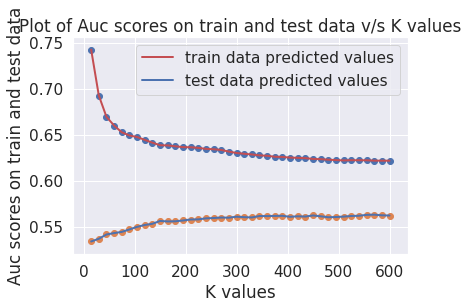

In [0]:
import matplotlib.pyplot as plt
plt.title('Plot of Auc scores on train and test data v/s K values')
plt.plot(k, auc_score_7, linewidth=2, color='r', label='train data predicted values')
plt.plot(k, auc_score_8, linewidth=2, color='b', label='test data predicted values')
plt.scatter(k, auc_score_7)
plt.scatter(k, auc_score_8)
plt.xlabel('K values')
plt.ylabel('Auc scores on train and test data')
plt.legend()
plt.show()

In [0]:
print('Best train and test AUC scores ocurr at k=400')
best_k4=400

Best train and test AUC scores ocurr at k=400


In [0]:
neighbor = KNeighborsClassifier(n_neighbors=best_k4, algorithm='brute', n_jobs=-1)
knn_4=neighbor.fit(pca_data_train, Y_tr)
Y_pred_k3=batch_predict(knn_4, pca_data_test)
auc_score = roc_auc_score(Y_test, Y_pred_k3)
print(' The AUC score at best k = {} on test data for model M1 is {}'.format(best_k4, auc_score))

 The AUC score at best k = 400 on test data for model M1 is 0.5533433293695105


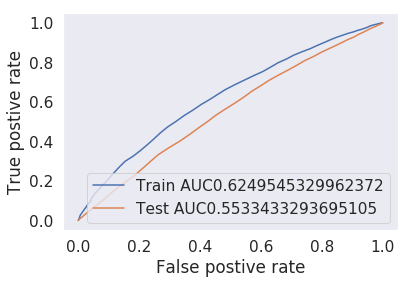

In [0]:
neighbor = KNeighborsClassifier(n_neighbors=best_k4, algorithm='brute')
knn_4=neighbor.fit(pca_data_train, Y_tr)
Y_1=batch_predict(knn_4, pca_data_train)
train_fpr, train_tpr, train_threshold = roc_curve(Y_tr, Y_1)
Y_2=batch_predict(knn_4, pca_data_test)
test_fpr, test_tpr, test_threshold = roc_curve(Y_test, Y_2)
plt.plot(train_fpr, train_tpr, label='Train AUC' + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label='Test AUC' + str(auc(test_fpr, test_tpr)))
plt.xlabel('False postive rate')
plt.ylabel('True postive rate')
plt.grid()
plt.legend()
plt.show()

In [0]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(train_threshold, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(Y_tr, predict_with_best_t(Y_1, best_t)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, predict_with_best_t(Y_2, best_t)))

the maximum value of tpr*(1-fpr) 0.3497429513336562 for threshold 0.852
Train confusion matrix
[[ 2448  1656]
 [ 9444 13386]]
Test confusion matrix
[[1467 1551]
 [6830 9952]]


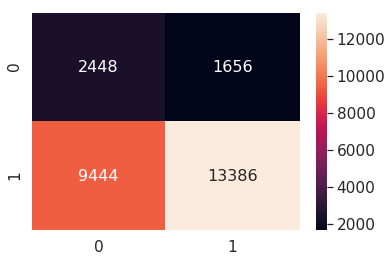

In [0]:


confusion_matrix_tr_df2=pd.DataFrame(confusion_matrix(Y_tr, predict_with_best_t(Y_1, best_t)))
sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix_tr_df2, annot=True, annot_kws={'size':16}, fmt='g')

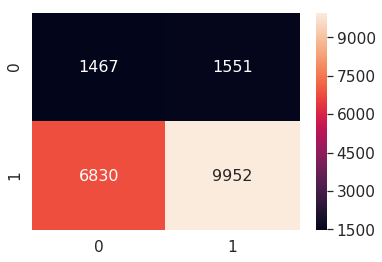

In [0]:


confusion_matrix_test_df2=pd.DataFrame(confusion_matrix(Y_test, predict_with_best_t(Y_2, best_t)))
sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix_test_df2, annot=True, annot_kws={'size':16}, fmt='g')

In [0]:
#SET 5:- Select K Best:

In [0]:
print(X_train_2.shape)
print(X_test_2.shape)
print(X_cv_2.shape)
print(Y_tr.shape)
print(Y_test.shape)
print(Y_cv.shape)

(26934, 3512)
(19800, 3512)
(13266, 3512)
(26934,)
(19800,)
(13266,)


In [0]:
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
Sel_k=SelectKBest(chi2, k=2000).fit(X_train_2, Y_tr)
X_tr_2=Sel_k.transform(X_train_2)
X_te_2=Sel_k.transform(X_test_2)
X_cv_2=Sel_k.transform(X_cv_2)

In [0]:
import math
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
auc_score_9=list()
auc_score_10=list()

In [0]:
from sklearn.neighbors import KNeighborsClassifier
for i in tqdm(k):
    neighbour =  KNeighborsClassifier(n_neighbors=i, algorithm = 'brute')
    clf=neighbour.fit(X_tr_2, Y_tr)
    Y_pred_7=batch_predict(clf, X_tr_2)
    Y_pred_8=batch_predict(clf, X_cv_2)
    auc_7=roc_auc_score(Y_tr, Y_pred_7)
    auc_score_9.append(auc_7)
    auc_8=roc_auc_score(Y_cv, Y_pred_8)
    auc_score_10.append(auc_8)



  0%|          | 0/40 [00:00<?, ?it/s]

  2%|▎         | 1/40 [01:31<59:35, 91.69s/it]

  5%|▌         | 2/40 [03:03<58:02, 91.64s/it]

  8%|▊         | 3/40 [04:34<56:29, 91.61s/it]

 10%|█         | 4/40 [06:06<54:56, 91.58s/it]

 12%|█▎        | 5/40 [07:38<53:27, 91.63s/it]

 15%|█▌        | 6/40 [09:10<51:58, 91.74s/it]

 18%|█▊        | 7/40 [10:41<50:28, 91.77s/it]

 20%|██        | 8/40 [12:13<48:57, 91.81s/it]

 22%|██▎       | 9/40 [13:45<47:29, 91.93s/it]

 25%|██▌       | 10/40 [15:18<46:00, 92.00s/it]

 28%|██▊       | 11/40 [16:50<44:29, 92.06s/it]

 30%|███       | 12/40 [18:22<43:00, 92.17s/it]

 32%|███▎      | 13/40 [19:55<41:31, 92.29s/it]

 35%|███▌      | 14/40 [21:27<40:01, 92.38s/it]

 38%|███▊      | 15/40 [23:00<38:31, 92.46s/it]

 40%|████      | 16/40 [24:33<37:03, 92.64s/it]

 42%|████▎     | 17/40 [26:06<35:32, 92.73s/it]

 45%|████▌     | 18/40 [27:39<34:02, 92.84s/it]

 48%|████▊     | 19/40 [29:13<32:33, 93.00s/it]

 50%|█████     | 20/40 [30:46<31:01,

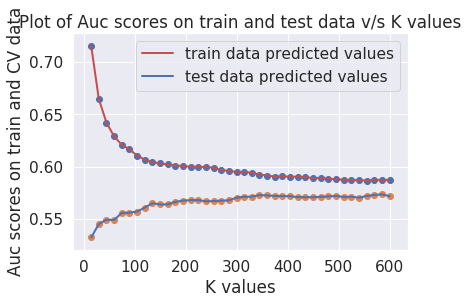

In [0]:
import matplotlib.pyplot as plt
plt.title('Plot of Auc scores on train and test data v/s K values')
plt.plot(k, auc_score_9, linewidth=2, color='r', label='train data predicted values')
plt.plot(k, auc_score_10, linewidth=2, color='b', label='test data predicted values')
plt.scatter(k, auc_score_9)
plt.scatter(k, auc_score_10)
plt.xlabel('K values')
plt.ylabel('Auc scores on train and CV data')
plt.legend()
plt.show()

In [0]:
print('Best train and test AUC scores ocurr at k=585')
best_k5=585

Best train and test AUC scores ocurr at k=585


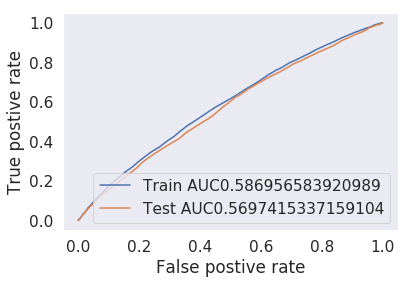

In [0]:
neighbor = KNeighborsClassifier(n_neighbors=best_k5, algorithm='brute')
knn_5=neighbor.fit(X_tr_2, Y_tr)
Y_1=batch_predict(knn_5, X_tr_2)
train_fpr, train_tpr, train_threshold = roc_curve(Y_tr, Y_1)
Y_2=batch_predict(knn_5, X_te_2)
test_fpr, test_tpr, test_threshold = roc_curve(Y_test, Y_2)
plt.plot(train_fpr, train_tpr, label='Train AUC' + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label='Test AUC' + str(auc(test_fpr, test_tpr)))
plt.xlabel('False postive rate')
plt.ylabel('True postive rate')
plt.grid()
plt.legend()
plt.show()

In [0]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(train_threshold, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(Y_tr, predict_with_best_t(Y_1, best_t)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, predict_with_best_t(Y_2, best_t)))

the maximum value of tpr*(1-fpr) 0.31480187913205415 for threshold 0.844
Train confusion matrix
[[ 2342  1762]
 [10236 12594]]
Test confusion matrix
[[1647 1371]
 [7623 9159]]


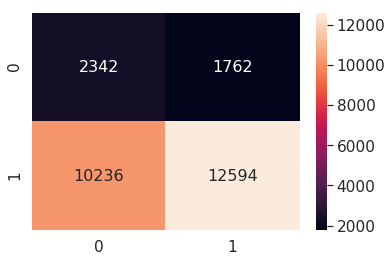

In [0]:
confusion_matrix(Y_tr, predict_with_best_t(Y_1, best_t))

confusion_matrix_test_df2=pd.DataFrame(confusion_matrix(Y_tr, predict_with_best_t(Y_1, best_t)))
sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix_test_df2, annot=True, annot_kws={'size':16}, fmt='g')

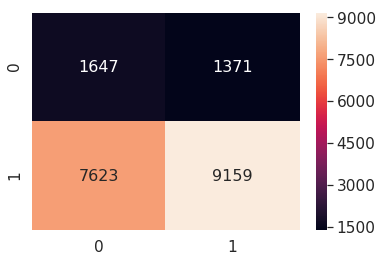

In [0]:
confusion_matrix(Y_test, predict_with_best_t(Y_2, best_t))

confusion_matrix_test_df2=pd.DataFrame(confusion_matrix(Y_test, predict_with_best_t(Y_2, best_t)))
sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix_test_df2, annot=True, annot_kws={'size':16}, fmt='g')

In [0]:
#Summarizing results:-

In [0]:
from prettytable import PrettyTable
x=PrettyTable()

In [0]:
x.field_names=['Technique', 'Best K', 'Train AUC', 'Test AUC']

In [0]:
x.add_row(['BOW','50','0.68','0.59'])
x.add_row(['TFIDF','35','0.66','0.55'])
x.add_row(['AVG_W2V','30','0.69','0.54'])
x.add_row(['TFIDF_W2V','25','0.67','0.53'])

In [0]:
print(x)

In [0]:
#Conclusions:-

In [0]:
1. 